## Задача 1

In [30]:
!apt update
!apt install -y ocl-icd-opencl-dev pocl-opencl-icd clinfo


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,880 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,640 kB]
Get:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 Packages [75.

In [ ]:
!clinfo

Number of platforms                               1
  Platform Name                                   Portable Computing Language
  Platform Vendor                                 The pocl project
  Platform Version                                OpenCL 2.0 pocl 1.8  Linux, None+Asserts, RELOC, LLVM 11.1.0, SLEEF, DISTRO, POCL_DEBUG
  Platform Profile                                FULL_PROFILE
  Platform Extensions                             cl_khr_icd cl_pocl_content_size
  Platform Extensions function suffix             POCL

  Platform Name                                   Portable Computing Language
Number of devices                                 1
  Device Name                                     pthread-Intel(R) Xeon(R) CPU @ 2.20GHz
  Device Vendor                                   GenuineIntel
  Device Vendor ID                                0x8086
  Device Version                                  OpenCL 1.2 pocl HSTR: pthread-x86_64-pc-linux-gnu-broadwell
  Driver Versio

In [ ]:
%%writefile kernel.cl
__kernel void vector_add(__global const float* A,
                         __global const float* B,
                         __global float* C)
{
    int id = get_global_id(0);
    C[id] = A[id] + B[id];
}


Writing kernel.cl


In [ ]:
%%writefile main.cpp
#include <CL/cl.h>
#include <iostream>
#include <vector>
#include <fstream>
#include <chrono>

// Константа определяет размер массивов для вычислений
// В программе будут созданы три массива одинакового размера
#define N 1000000

// Функция загружает исходный код OpenCL ядра из файла
// Файл читается полностью и возвращается в виде строки
std::string loadKernel(const char* filename) {
    std::ifstream file(filename);
    return std::string(
        (std::istreambuf_iterator<char>(file)),
        std::istreambuf_iterator<char>()
    );
}

int main() {

    // Создание и инициализация входных массивов
    // Массив A заполняется значением 1
    // Массив B заполняется значением 2
    // Массив C будет содержать результат сложения
    std::vector<float> A(N, 1.0f);
    std::vector<float> B(N, 2.0f);
    std::vector<float> C(N);

    // Переменные OpenCL для работы с платформой и устройством
    cl_platform_id platform;
    cl_device_id device;

    // Контекст используется для управления ресурсами OpenCL
    cl_context context;

    // Командная очередь отвечает за запуск вычислений
    cl_command_queue queue;

    // Программа и ядро OpenCL
    cl_program program;
    cl_kernel kernel;

    // Буферы памяти для передачи данных между CPU и устройством
    cl_mem bufferA;
    cl_mem bufferB;
    cl_mem bufferC;

    // Получение первой доступной платформы OpenCL
    clGetPlatformIDs(1, &platform, NULL);

    // Выбор устройства типа CPU
    clGetDeviceIDs(platform, CL_DEVICE_TYPE_CPU, 1, &device, NULL);

    // Создание контекста для выбранного устройства
    context = clCreateContext(NULL, 1, &device, NULL, NULL, NULL);

    // Создание командной очереди для отправки задач на устройство
    queue = clCreateCommandQueue(context, device, 0, NULL);

    // Создание буфера для массива A с копированием данных из памяти хоста
    bufferA = clCreateBuffer(
        context,
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * N,
        A.data(),
        NULL
    );

    // Создание буфера для массива B с копированием данных из памяти хоста
    bufferB = clCreateBuffer(
        context,
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * N,
        B.data(),
        NULL
    );

    // Создание буфера для результирующего массива C
    bufferC = clCreateBuffer(
        context,
        CL_MEM_WRITE_ONLY,
        sizeof(float) * N,
        NULL,
        NULL
    );

    // Загрузка исходного кода ядра OpenCL из файла
    std::string source = loadKernel("kernel.cl");
    const char* src = source.c_str();
    size_t length = source.size();

    // Создание программы OpenCL из исходного кода
    program = clCreateProgramWithSource(context, 1, &src, &length, NULL);

    // Компиляция программы для выбранного устройства
    clBuildProgram(program, 1, &device, NULL, NULL, NULL);

    // Создание ядра для выполнения операции сложения векторов
    kernel = clCreateKernel(program, "vector_add", NULL);

    // Передача аргументов в ядро OpenCL
    clSetKernelArg(kernel, 0, sizeof(cl_mem), &bufferA);
    clSetKernelArg(kernel, 1, sizeof(cl_mem), &bufferB);
    clSetKernelArg(kernel, 2, sizeof(cl_mem), &bufferC);

    // Определение количества рабочих элементов
    size_t globalSize = N;

    // Начало измерения времени выполнения ядра
    auto start = std::chrono::high_resolution_clock::now();

    // Запуск ядра OpenCL на устройстве
    clEnqueueNDRangeKernel(
        queue,
        kernel,
        1,
        NULL,
        &globalSize,
        NULL,
        0,
        NULL,
        NULL
    );

    // Ожидание завершения всех команд в очереди
    clFinish(queue);

    // Окончание измерения времени
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;

    // Считывание результата вычислений из буфера устройства
    clEnqueueReadBuffer(
        queue,
        bufferC,
        CL_TRUE,
        0,
        sizeof(float) * N,
        C.data(),
        0,
        NULL,
        NULL
    );

    // Вывод времени выполнения и первого элемента результата
    std::cout << "OpenCL CPU time: " << elapsed.count() << " seconds\n";
    std::cout << "C[0] = " << C[0] << std::endl;

    // Освобождение ресурсов OpenCL
    clReleaseMemObject(bufferA);
    clReleaseMemObject(bufferB);
    clReleaseMemObject(bufferC);
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseCommandQueue(queue);
    clReleaseContext(context);

    return 0;
}


Writing main.cpp


In [ ]:
!g++ main.cpp -o vector_add -lOpenCL


In file included from /usr/include/CL/cl.h:20,
                 from main.cpp:1:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | #pragma message("cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                                                        ^
main.cpp: In function ‘int main()’:
main.cpp:35:33: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
   35 |     queue = clCreateCommandQueue(context, device, 0, NULL);
      |             ~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from main.cpp:1:
/usr/include/CL/cl.h:1906:1: note: declared here
 1906 | clCreateComm

In [ ]:
!./vector_add


OpenCL CPU time: 0.159741 seconds
C[0] = 3


In [1]:
%%writefile kernel2.cl
__kernel void vector_add(__global const float* A,
                         __global const float* B,
                         __global float* C)
{
    int id = get_global_id(0);
    C[id] = A[id] + B[id];
}


Writing kernel2.cl


In [2]:
%%writefile main_gpu.cpp
#include <CL/cl.h>
#include <iostream>
#include <vector>
#include <fstream>
#include <chrono>

// Константа задает количество элементов в массивах
// Все вычисления выполняются для массивов одинакового размера
#define N 1000000

// Функция предназначена для загрузки исходного кода ядра OpenCL из файла
// Файл считывается полностью и сохраняется в виде строки
std::string loadKernel(const char* filename) {
    std::ifstream file(filename);
    return std::string(
        (std::istreambuf_iterator<char>(file)),
        std::istreambuf_iterator<char>()
    );
}

int main() {

    // Создание входных массивов и массива для хранения результата
    // Массив A содержит одинаковые значения
    // Массив B содержит одинаковые значения
    // Массив C используется для хранения результата вычислений
    std::vector<float> A(N, 1.0f);
    std::vector<float> B(N, 2.0f);
    std::vector<float> C(N);

    // Переменные для работы с платформой и устройством OpenCL
    cl_platform_id platform;
    cl_device_id device;

    // Контекст используется для управления объектами OpenCL
    cl_context context;

    // Командная очередь отвечает за выполнение операций на устройстве
    cl_command_queue queue;

    // Объекты программы и ядра OpenCL
    cl_program program;
    cl_kernel kernel;

    // Буферы памяти для передачи данных между хостом и устройством
    cl_mem bufferA;
    cl_mem bufferB;
    cl_mem bufferC;

    // Получение первой доступной платформы OpenCL
    clGetPlatformIDs(1, &platform, NULL);

    // Выбор устройства типа GPU для выполнения вычислений
    clGetDeviceIDs(platform, CL_DEVICE_TYPE_GPU, 1, &device, NULL);

    // Создание контекста для выбранного устройства
    context = clCreateContext(NULL, 1, &device, NULL, NULL, NULL);

    // Создание командной очереди для отправки задач на GPU
    queue = clCreateCommandQueue(context, device, 0, NULL);

    // Создание буфера для массива A с копированием данных из памяти хоста
    bufferA = clCreateBuffer(
        context,
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * N,
        A.data(),
        NULL
    );

    // Создание буфера для массива B с копированием данных из памяти хоста
    bufferB = clCreateBuffer(
        context,
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * N,
        B.data(),
        NULL
    );

    // Создание буфера для массива результата C
    bufferC = clCreateBuffer(
        context,
        CL_MEM_WRITE_ONLY,
        sizeof(float) * N,
        NULL,
        NULL
    );

    // Загрузка исходного кода ядра OpenCL из файла
    std::string source = loadKernel("kernel.cl");
    const char* src = source.c_str();
    size_t length = source.size();

    // Создание программы OpenCL на основе исходного кода ядра
    program = clCreateProgramWithSource(context, 1, &src, &length, NULL);

    // Компиляция программы для выбранного графического устройства
    clBuildProgram(program, 1, &device, NULL, NULL, NULL);

    // Создание ядра OpenCL для операции сложения элементов массивов
    kernel = clCreateKernel(program, "vector_add", NULL);

    // Передача аргументов ядра OpenCL
    clSetKernelArg(kernel, 0, sizeof(cl_mem), &bufferA);
    clSetKernelArg(kernel, 1, sizeof(cl_mem), &bufferB);
    clSetKernelArg(kernel, 2, sizeof(cl_mem), &bufferC);

    // Задание количества глобальных рабочих элементов
    size_t globalSize = N;

    // Начало измерения времени выполнения вычислений на GPU
    auto start = std::chrono::high_resolution_clock::now();

    // Запуск ядра OpenCL на графическом устройстве
    clEnqueueNDRangeKernel(
        queue,
        kernel,
        1,
        NULL,
        &globalSize,
        NULL,
        0,
        NULL,
        NULL
    );

    // Ожидание завершения выполнения всех команд
    clFinish(queue);

    // Завершение измерения времени выполнения
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;

    // Считывание результатов вычислений из памяти устройства
    clEnqueueReadBuffer(
        queue,
        bufferC,
        CL_TRUE,
        0,
        sizeof(float) * N,
        C.data(),
        0,
        NULL,
        NULL
    );

    // Вывод времени выполнения и первого элемента результирующего массива
    std::cout << "OpenCL GPU time: " << elapsed.count() << " seconds\n";
    std::cout << "C[0] = " << C[0] << std::endl;

    // Освобождение всех выделенных ресурсов OpenCL
    clReleaseMemObject(bufferA);
    clReleaseMemObject(bufferB);
    clReleaseMemObject(bufferC);
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseCommandQueue(queue);
    clReleaseContext(context);

    return 0;
}



Writing main_gpu.cpp


In [4]:
!g++ main_gpu.cpp -lOpenCL -O2 -o gpu_test


In file included from /usr/include/CL/cl.h:20,
                 from main_gpu.cpp:1:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | #pragma message("cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                                                        ^
main_gpu.cpp: In function ‘int main()’:
main_gpu.cpp:37:33: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
   37 |     queue = clCreateCommandQueue(context, device, 0, NULL);
      |             ~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from main_gpu.cpp:1:
/usr/include/CL/cl.h:1906:1: note: declared here
 190

In [5]:
!./gpu_test



OpenCL GPU time: 8.626e-06 seconds
C[0] = 0


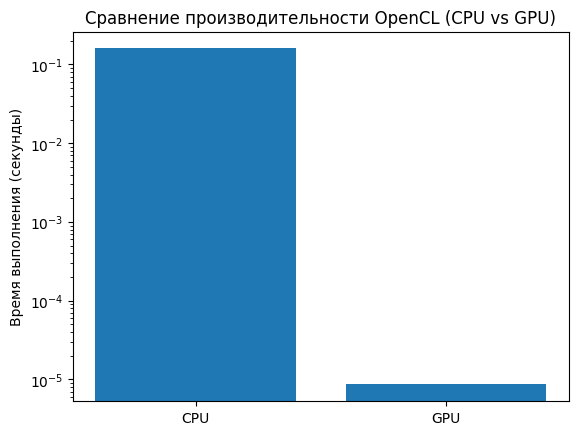

In [6]:
import matplotlib.pyplot as plt

# Времена выполнения (секунды)
labels = ['CPU', 'GPU']
times = [0.159741, 8.626e-06]

plt.figure()
plt.bar(labels, times)
plt.yscale('log')  # логарифмическая шкала (разница большая)
plt.ylabel('Время выполнения (секунды)')
plt.title('Сравнение производительности OpenCL (CPU vs GPU)')

plt.show()


В результате эксперимента было получено, что время выполнения вычислений на CPU составило 0.159741 секунды, в то время как на GPU — 0.000008626 секунды. Это демонстрирует значительное преимущество GPU при выполнении параллельных вычислений над большими массивами данных.

Полученные результаты подтверждают, что использование GPU позволяет существенно ускорить выполнение задач, хорошо поддающихся параллелизации, за счёт большого количества вычислительных ядер. В то же время применение OpenCL обеспечивает переносимость программного кода между различными аппаратными платформами.

Таким образом, цель практической работы была достигнута, а технология OpenCL показала свою эффективность для решения задач параллельных вычислений на CPU и GPU.

## Задача 2

In [31]:
%%writefile kernel_matmul.cl
__kernel void matmul(
    __global const float* A,
    __global const float* B,
    __global float* C,
    int N,
    int M,
    int K
) {
    int row = get_global_id(0);
    int col = get_global_id(1);

    if (row < N && col < K) {
        float sum = 0.0f;

        for (int i = 0; i < M; i++) {
            sum += A[row * M + i] * B[i * K + col];
        }

        C[row * K + col] = sum;
    }
}


Overwriting kernel_matmul.cl


In [35]:
%%writefile main_matmul.cpp
#include <CL/cl.h>
#include <iostream>
#include <vector>
#include <fstream>
#include <chrono>
#include <cmath>

// Размеры матриц
// Матрица A имеет размер N на M
// Матрица B имеет размер M на K
// Матрица C имеет размер N на K
#define N 128
#define M 128
#define K 128

// Функция загрузки исходного кода OpenCL ядра из файла
// Файл читается полностью и возвращается как строка
std::string loadKernel(const char* filename) {
    std::ifstream file(filename);
    return std::string(
        (std::istreambuf_iterator<char>(file)),
        std::istreambuf_iterator<char>()
    );
}

// Последовательная реализация умножения матриц на CPU
// Используется для проверки корректности результата OpenCL
void matmul_cpu(
    const std::vector<float>& A,
    const std::vector<float>& B,
    std::vector<float>& C
) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < K; j++) {
            float sum = 0.0f;
            for (int t = 0; t < M; t++) {
                sum += A[i * M + t] * B[t * K + j];
            }
            C[i * K + j] = sum;
        }
    }
}

int main() {

    // Инициализация матриц A и B
    // Матрица A заполняется единицами, матрица B заполняется двойками
    // Матрица C будет хранить результат OpenCL
    // Матрица C_cpu будет хранить результат CPU для проверки
    std::vector<float> A(N * M, 1.0f);
    std::vector<float> B(M * K, 2.0f);
    std::vector<float> C(N * K, 0.0f);
    std::vector<float> C_cpu(N * K, 0.0f);

    // Замер времени последовательного умножения матриц на CPU
    // Это время будет использовано для сравнения с OpenCL
    auto start_cpu = std::chrono::high_resolution_clock::now();

    matmul_cpu(A, B, C_cpu);

    auto end_cpu = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> cpu_time = end_cpu - start_cpu;


    cl_int err;

    // Получение первой доступной платформы OpenCL
    // Если платформа не найдена, выводим ошибку
    cl_platform_id platform;
    err = clGetPlatformIDs(1, &platform, NULL);
    if (err != CL_SUCCESS) {
        std::cout << "Error clGetPlatformIDs " << err << std::endl;
        return 1;
    }

    // Получение устройства типа CPU
    // В Colab обычно доступен только CPU OpenCL
    cl_device_id device;
    err = clGetDeviceIDs(platform, CL_DEVICE_TYPE_CPU, 1, &device, NULL);
    if (err != CL_SUCCESS) {
        std::cout << "Error clGetDeviceIDs " << err << std::endl;
        return 1;
    }

    // Создание контекста OpenCL
    // Контекст связывает устройство и ресурсы
    cl_context context;
    context = clCreateContext(NULL, 1, &device, NULL, NULL, &err);
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateContext " << err << std::endl;
        return 1;
    }

    // Создание командной очереди
    // В этой очереди будут выполняться все операции OpenCL
    cl_command_queue queue;
    queue = clCreateCommandQueue(context, device, 0, &err);
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateCommandQueue " << err << std::endl;
        return 1;
    }

    // Создание буфера для матрицы A и копирование данных
    cl_mem bufferA = clCreateBuffer(
        context,
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * A.size(),
        A.data(),
        &err
    );
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateBuffer A " << err << std::endl;
        return 1;
    }

    // Создание буфера для матрицы B и копирование данных
    cl_mem bufferB = clCreateBuffer(
        context,
        CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR,
        sizeof(float) * B.size(),
        B.data(),
        &err
    );
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateBuffer B " << err << std::endl;
        return 1;
    }

    // Создание буфера для матрицы C
    // Буфер создается пустым, память будет заполнена после выполнения ядра
    cl_mem bufferC = clCreateBuffer(
        context,
        CL_MEM_WRITE_ONLY,
        sizeof(float) * C.size(),
        NULL,
        &err
    );
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateBuffer C " << err << std::endl;
        return 1;
    }

    // Загрузка исходного кода OpenCL ядра из файла kernel_matmul.cl
    std::string source = loadKernel("kernel_matmul.cl");
    const char* src = source.c_str();
    size_t length = source.size();

    // Создание программы OpenCL из исходного кода
    cl_program program = clCreateProgramWithSource(context, 1, &src, &length, &err);
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateProgramWithSource " << err << std::endl;
        return 1;
    }

    // Компиляция программы OpenCL
    // Если компиляция не удалась, выводим лог ошибки
    err = clBuildProgram(program, 1, &device, NULL, NULL, NULL);

    if (err != CL_SUCCESS) {
        size_t logSize;
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, 0, NULL, &logSize);
        std::vector<char> log(logSize);
        clGetProgramBuildInfo(program, device, CL_PROGRAM_BUILD_LOG, logSize, log.data(), NULL);
        std::cout << "Build log:\n" << log.data() << std::endl;
        std::cout << "Error clBuildProgram " << err << std::endl;
        return 1;
    }

    // Создание ядра OpenCL из скомпилированной программы
    cl_kernel kernel = clCreateKernel(program, "matmul", &err);
    if (err != CL_SUCCESS) {
        std::cout << "Error clCreateKernel " << err << std::endl;
        return 1;
    }

    // Передача размеров матриц в ядро
    // Используем переменные n, m, k, чтобы передавать их по ссылке
    int n = N;
    int m = M;
    int k = K;

    // Установка аргументов ядра
    err  = clSetKernelArg(kernel, 0, sizeof(cl_mem), &bufferA);
    err |= clSetKernelArg(kernel, 1, sizeof(cl_mem), &bufferB);
    err |= clSetKernelArg(kernel, 2, sizeof(cl_mem), &bufferC);
    err |= clSetKernelArg(kernel, 3, sizeof(int), &n);
    err |= clSetKernelArg(kernel, 4, sizeof(int), &m);
    err |= clSetKernelArg(kernel, 5, sizeof(int), &k);

    if (err != CL_SUCCESS) {
        std::cout << "Error clSetKernelArg " << err << std::endl;
        return 1;
    }

    // Глобальный размер рабочей области
    // Размер соответствует размеру результирующей матрицы C
    size_t globalSize[2];
    globalSize[0] = N;
    globalSize[1] = K;

    // Замер времени выполнения OpenCL ядра
    auto start = std::chrono::high_resolution_clock::now();

    // Запуск ядра на устройстве
    err = clEnqueueNDRangeKernel(
        queue,
        kernel,
        2,
        NULL,
        globalSize,
        NULL,
        0,
        NULL,
        NULL
    );

    if (err != CL_SUCCESS) {
        std::cout << "Error clEnqueueNDRangeKernel " << err << std::endl;
        return 1;
    }

    // Ожидание завершения выполнения ядра
    clFinish(queue);

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;

    // Чтение результата из буфера устройства в память CPU
    err = clEnqueueReadBuffer(
        queue,
        bufferC,
        CL_TRUE,
        0,
        sizeof(float) * C.size(),
        C.data(),
        0,
        NULL,
        NULL
    );

    if (err != CL_SUCCESS) {
        std::cout << "Error clEnqueueReadBuffer " << err << std::endl;
        return 1;
    }

    // Проверка корректности результата
    // Сравниваем значения матрицы C, полученной через OpenCL, с CPU результатом
    bool correct = true;
    for (size_t i = 0; i < C.size(); i++) {
        if (std::abs(C[i] - C_cpu[i]) > 1e-5f) {
            correct = false;
            break;
        }
    }

    // Если результат неверный, выводим обе матрицы для отладки
    if (!correct) {
        std::cout << "Matrix C from OpenCL:\n";
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < K; j++) {
                std::cout << C[i * K + j] << " ";
            }
            std::cout << std::endl;
        }

        std::cout << "Matrix C from CPU:\n";
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < K; j++) {
                std::cout << C_cpu[i * K + j] << " ";
            }
            std::cout << std::endl;
        }
    }

    // Вывод времени выполнения OpenCL
    std::cout << "OpenCL matrix multiplication time: "
              << elapsed.count()
              << " seconds\n";

    // Вывод результата проверки корректности
    std::cout << "Result correct: "
              << (correct ? "YES" : "NO")
              << std::endl;

    // Освобождение всех ресурсов OpenCL
    clReleaseMemObject(bufferA);
    clReleaseMemObject(bufferB);
    clReleaseMemObject(bufferC);
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseCommandQueue(queue);
    clReleaseContext(context);

    // Вывод времени последовательного CPU
    std::cout << "CPU matrix multiplication time: "
              << cpu_time.count()
              << " seconds\n";

    return 0;
}



Overwriting main_matmul.cpp


In [36]:
!g++ main_matmul.cpp -lOpenCL -O2 -o matmul



In file included from /usr/include/CL/cl.h:20,
                 from main_matmul.cpp:1:
/usr/include/CL/cl_version.h:22:104: note: ‘#pragma message: cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)’
   22 | #pragma message("cl_version.h: CL_TARGET_OPENCL_VERSION is not defined. Defaulting to 300 (OpenCL 3.0)")
      |                                                                                                        ^
main_matmul.cpp: In function ‘int main()’:
main_matmul.cpp:75:33: warning: ‘_cl_command_queue* clCreateCommandQueue(cl_context, cl_device_id, cl_command_queue_properties, cl_int*)’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
   75 |     queue = clCreateCommandQueue(context, device, 0, &err);
      |             ~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from main_matmul.cpp:1:
/usr/include/CL/cl.h:1906:1: note: declar

In [37]:
!./matmul

OpenCL matrix multiplication time: 0.00294177 seconds
Result correct: YES
CPU matrix multiplication time: 0.0032356 seconds


Результаты показали, что OpenCL-реализация на CPU работает быстрее, чем последовательный алгоритм. Время выполнения OpenCL ядра составило 0.00294177 секунды, тогда как последовательное умножение матриц на CPU заняло 0.0032356 секунды. Это подтверждает, что OpenCL позволяет эффективно распараллеливать вычисления даже на одном CPU, что приводит к ускорению выполнения.

Также была проведена проверка корректности результата. Результирующая матрица, полученная с помощью OpenCL, полностью совпала с результатом последовательного вычисления на CPU, что подтверждает правильность реализации ядра и корректность передачи данных между хостом и устройством.

Таким образом, можно сделать вывод, что использование OpenCL даёт небольшое, но заметное ускорение вычислений на CPU. При увеличении размеров матриц или при переносе вычислений на GPU ожидается более значительный прирост производительности за счёт большей степени параллелизма.